In [445]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle

In [406]:
BASE_PATH = "./data/chest_xray/"
TRAIN_DIR = BASE_PATH + "train/"
VAL_DIR =  BASE_PATH + "val/"
TEST_DIR =  BASE_PATH + "test/"
LABELS = ['NORMAL', 'PNEUMONIA']

for data_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for label in LABELS:
        count = len(os.listdir(data_dir + label))
        print('{0} {1} # {2}'.format(label, data_dir, count))

NORMAL ./data/chest_xray/train/ # 1332
PNEUMONIA ./data/chest_xray/train/ # 3870
NORMAL ./data/chest_xray/val/ # 19
PNEUMONIA ./data/chest_xray/val/ # 15
NORMAL ./data/chest_xray/test/ # 234
PNEUMONIA ./data/chest_xray/test/ # 390


In [423]:
total_train = len(os.listdir(TRAIN_DIR + 'NORMAL')) + len(os.listdir(TRAIN_DIR + 'PNEUMONIA'))
total_val = len(os.listdir(VAL_DIR + 'NORMAL')) + len(os.listdir(VAL_DIR + 'PNEUMONIA'))
total_test = len(os.listdir(TEST_DIR + 'NORMAL')) + len(os.listdir(TEST_DIR + 'PNEUMONIA'))
(total_train, total_val, total_test)

(5202, 34, 624)

NORMAL


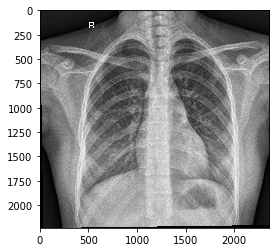

PNEUMONIA


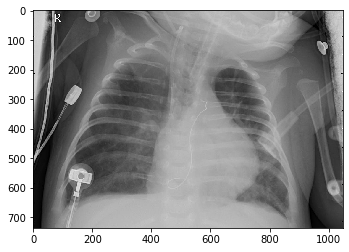

In [408]:
for label in LABELS:
    path = TRAIN_DIR + label
    img = os.listdir(path)[0]
    img_normal = load_img(path + '/' + img)
    print(label)
    plt.imshow(img_normal)
    plt.show()


In [409]:
img_width, img_height = 150, 150
batch_size = 32

In [410]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

Found 5200 images belonging to 2 classes.


In [411]:
val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

Found 32 images belonging to 2 classes.


In [447]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [449]:
epochs = 15
strides_list = [2]
kernels = [2]
layers_list = [
#     [32,64,128],
    [32,64,64,64]
#     [64,128,256],  
#     [128,256,512]
]
force = True
for strides in strides_list:
    for kernel in kernels:
        for layers in layers_list:
            key = 'S:{0}-K:{1}-L:{2}'.format(str(strides), str(kernel), str(layers))            
            if (force or not (os.path.isfile(key))):
                print('Training: ' + key)
                model = Sequential()

                model = Sequential()
                model.add(Conv2D(layers[0], kernel, strides=strides, input_shape=(img_width, img_height, 1)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

                model.add(Conv2D(layers[1], kernel, strides=strides))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

                model.add(Conv2D(layers[2], kernel, strides=strides))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

#                 model.add(Conv2D(layers[3], 3, strides=strides))
#                 model.add(Activation('relu'))
#                 model.add(MaxPooling2D(pool_size=(3, 3)))
                
                model.add(Flatten())
                model.add(Dense(64))
                model.add(Activation('relu'))
                model.add(Dropout(rate=0.5))
                model.add(Dense(1))
                model.add(Activation('sigmoid'))

                model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

                checkpoint = ModelCheckpoint(key, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

                model.fit_generator(
                    train_generator,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=total_test // batch_size,
                    callbacks=[checkpoint]
                )
                
# Training: S:1-K:2-L:[32, 64, 128] - 0.90625 after 4 epochs, 100s per epoch
# Training: S:1-K:2-L:[64, 128, 256] - 0.84375 after 2 epochs, 250s per epoch
# Training: S:1-K:2-L:[128, 256, 512] - 0.84375 after 5 epochs, 700s per epoch

# Training: S:2-K:3-L:[32, 64, 128] - 0.87500 after 6 epochs, 50s per epoch
# Training: S:2-K:3-L:[64, 64, 64] - 0.93750 after 6 epochs, 50s per epoch
# Training: S:1-K:3-L:[32, 64, 128] - 0.93750 after 7 epochs, 124s per epoch
# Training: S:2-K:2-L:[32, 64, 128] - 0.93750 after 9 epochs, 50s per epoch
# Training: S:2-K:2-L:[64, 64, 64] - 0.93750 after 9 epochs, 50s per epoch

Training: S:2-K:2-L:[32, 64, 64, 64]
Epoch 1/15
162/162 [==============================] - 61s 376ms/step - loss: 0.5288 - acc: 0.7589 - val_loss: 0.5288 - val_acc: 0.7451

Epoch 00001: val_acc improved from -inf to 0.74507, saving model to S:2-K:2-L:[32, 64, 64, 64]
Epoch 2/15
162/162 [==============================] - 51s 314ms/step - loss: 0.3198 - acc: 0.8634 - val_loss: 0.5563 - val_acc: 0.7517

Epoch 00002: val_acc improved from 0.74507 to 0.75169, saving model to S:2-K:2-L:[32, 64, 64, 64]
Epoch 3/15
162/162 [==============================] - 58s 359ms/step - loss: 0.2010 - acc: 0.9234 - val_loss: 0.8424 - val_acc: 0.7213

Epoch 00003: val_acc did not improve from 0.75169
Epoch 4/15
162/162 [==============================] - 55s 340ms/step - loss: 0.1600 - acc: 0.9389 - val_loss: 0.5593 - val_acc: 0.8142

Epoch 00004: val_acc improved from 0.75169 to 0.81419, saving model to S:2-K:2-L:[32, 64, 64, 64]
Epoch 5/15
162/162 [==============================] - 50s 311ms/step - loss: 0

In [403]:
model = keras.models.load_model('checkpoint')

In [404]:
model.evaluate_generator(val_generator, total_val//batch_size)

[0.2384699583053589, 0.9375]